In [28]:
import random

import keras
import re
import os
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D,Dense, Flatten
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Dropout, Lambda
from keras.layers import concatenate
import glob
from keras.applications import ResNet50

## Load model

In [29]:
x0 = tf.keras.Input(	shape=(224, 224, 3))

x = tf.keras.layers.Lambda(tf.keras.applications.efficientnet_v2.preprocess_input, input_shape=(224, 224, 3))(x0)


In [30]:


layer = tf.keras.applications.EfficientNetV2B0(weights='imagenet',
											   include_top=False,
											   classes=3, input_shape=(224,224,3))
layer.build((None,224,224,3))  # Create the weights
layer.trainable = False  # Freeze the layer
layer.layers.pop()
layer.layers.pop()


x = layer(x)

In [31]:
# x = layer.layers[-2].output
x = Flatten()(x)

In [32]:
x

<KerasTensor: shape=(None, 62720) dtype=float32 (created by layer 'flatten_1')>

In [33]:
x = Dense(units=128, activation='relu')(x)
output = Dense(units=3, activation='softmax')(x)

In [34]:
model = Model(inputs=x0, outputs=output)

In [35]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               8028288   
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                           

## Load their data

In [36]:
from PIL import Image
import numpy as np
from tqdm import tqdm

def load_their(set):
    print(set)

    xdata = []
    ydata = []

    file_list = glob.glob(
        r"A:/F/%(set)s/*.png" % {"set": set})
    for file in tqdm(file_list, desc="Loading..."):
        classe = file[-6]
        if classe not in ["0", "2", "5"]:
            continue
        classe = {"2": 1, "0": 0, "5": 2}[classe]
        ydata.append(classe)
        # im = imread(file)

        image = Image.open(file)

        im = image.resize((224, 224))
        im = im.rotate(90, Image.NEAREST, expand = 1)

        # Transformer l'image redimensionnée en un tableau NumPy
        im = np.array(im)
        im = im.reshape((224,224,1))
        im = np.concatenate([im, im, im], axis=2)
        xdata.append(im[:, :, :3])

    return xdata, ydata

from sklearn.model_selection import train_test_split
xtrain, ytrain = load_their("train")
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.1, random_state=42, shuffle=True)
xtest, ytest = load_their("test")

train


Loading...:   0%|          | 0/18000 [00:00<?, ?it/s]C:\Users\iArno-Computer3\AppData\Local\Temp\ipykernel_19220\4251519404.py:24: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  im = im.rotate(90, Image.NEAREST, expand = 1)
Loading...: 100%|██████████| 18000/18000 [00:09<00:00, 1972.90it/s]


test


Loading...: 100%|██████████| 3600/3600 [00:01<00:00, 2086.50it/s]


## Load Data

In [37]:
# from tqdm import tqdm
# import random
# def load(set: str):
#     xtrain = []
#     ytrain = []
#     print(set)
#     train_num_files = 0
#     for source in ["Temps1", "Temps2", "Temps3"]:
#         print(source)
#         file_list = glob.glob(
#             r"A:/%(s)s/images/%(set)s/*.png" % {"s": source, "set": set})
#         if source == "Temps0":
#             file_list = random.choices(file_list, k=200)
#         # print(len(file_list))
#         for file in tqdm(file_list, desc="Loading..."):
#             p = 'A:/%(s)s/labels/%(set)s/' % {"s": source, "set": set}
#             file_label = p + file[len(p):]
#             file_label = file_label[:-4]
#             file_label = file_label+'.txt'
#             if os.path.isfile(file_label):
#                 f = open(file_label,"r+")
#                 a = f.read()
#                 if len(a)>=1:
#                     im = imread(file)[:, :, :3]
#                     train_num_files += 1
#                     xtrain.append(im)
#                     ytrain.append([int(a[0])])
#                 f.close()
#     return xtrain, ytrain
#
# xtrain, ytrain = load("train")
# xval, yval = load("val")
# xtest, ytest = load("test")
# # xtest2, ytest2 = load("train", mode="choices", k=200, sources=("Temps0",))

In [38]:
filepath = 'shifumi_from_mobil.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [39]:
import tensorflow_addons as tfa
f1_score = tfa.metrics.F1Score(num_classes = 3, average = None, name = "f1_score")

In [40]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])

In [41]:
from keras.utils import to_categorical

In [42]:
xtrain = np.asarray(xtrain)
xval = np.asarray(xval)
xtest = np.asarray(xtest)

In [43]:
ytrain = to_categorical(ytrain)
yval = to_categorical(yval)
ytest = to_categorical(ytest)

## Data augmentation

In [44]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        # featurewise_center=True,
        # featurewise_std_normalization=True,
        # rotation_range=60*factor,
        # width_shift_range=0.2*factor,
        # height_shift_range=0.2*factor,
        # brightness_range=(-1, 1),
        # zoom_range=(0.33*factor + (1-factor),1.3*factor + (1-factor)),
        horizontal_flip=True,
        # validation_split=0.1
    )
random.seed(42)
datagen.fit(xtrain)

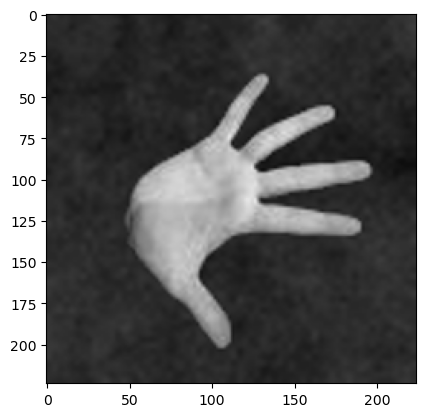

In [45]:
plt.imshow(datagen.random_transform(xtrain[350], seed=42))

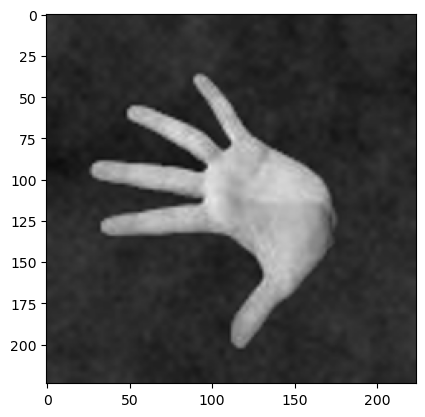

In [46]:
plt.imshow(xtrain[350])

In [47]:
import sys
sys.getsizeof(xtrain)

1219276952

## Train

In [48]:
# a  =datagen.flow(xtrain, ytrain, batch_size=10)
# from keras.utils import Sequence
# from itertools import groupby
# import random
#
#
# class DataGenerator(Sequence):
#     def __init__(self, x_set, y_set, batch_size, gen):
#         self.l = len(y_set)
#         self.gen = gen
#         self.x = x_set
#         self.y = y_set
#         self.batch_size = batch_size
#
#     def __len__(self):
#         return self.l
#
#     def __getitem__(self, idx):
#         x, y = self.gen(self.x, self.y, batch_size=self.batch_size)[idx]
#
#         x = tf.keras.applications.resnet50.preprocess_input(x, data_format=None) / 255
#
#         return x, y
#
# DataGenerator(xtrain, ytrain, batch_size=10, gen=datagen.flow)[0]

In [49]:
# xtrain = tf.keras.applications.resnet50.preprocess_input(xtrain, data_format=None)
# xval = tf.keras.applications.resnet50.preprocess_input(xval, data_format=None)
# xtest = tf.keras.applications.resnet50.preprocess_input(xtest, data_format=None)

In [50]:
# history = model.fit(datagen[-1].flow(xtrain, ytrain, batch_size=10),
# 						 validation_data=datagen[-1].flow(xval, yval, batch_size=10),
# 						 batch_size=10,
# 						 # steps_per_epoch=len(xtrain) // 10,
# 						 epochs=10, verbose=1, callbacks=callbacks)

In [51]:
history = model.fit(datagen.flow(xtrain, ytrain, batch_size=10),
      validation_data=datagen.flow(xval, yval, batch_size=10),
      batch_size=10,
      # steps_per_epoch=len(xtrain) // 10,
      epochs=3, verbose=1)

Epoch 1/3
810/810 [==============================] - 34s 34ms/step - loss: 0.0463 - accuracy: 0.9969 - f1_score: 0.9969 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_f1_score: 1.0000
Epoch 2/3
810/810 [==============================] - 26s 32ms/step - loss: 0.1228 - accuracy: 0.9969 - f1_score: 0.9969 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_f1_score: 1.0000
Epoch 3/3
810/810 [==============================] - 27s 33ms/step - loss: 8.2561e-09 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_f1_score: 1.0000


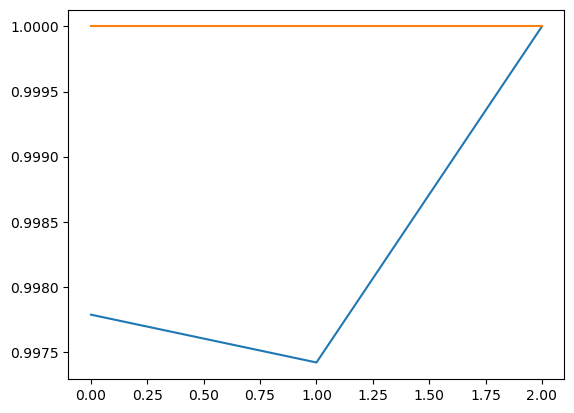

In [54]:
import matplotlib.pyplot as plt
f1 = np.array(history.history["f1_score"])[:, 2]
val_f1 = np.array(history.history["val_f1_score"])[:, 2]

plt.plot(f1)
plt.plot(val_f1)
plt.show()

In [55]:
model.evaluate(xtest, ytest)

57/57 [==============================] - 5s 51ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - f1_score: 1.0000


[0.0, 1.0, array([1., 1., 1.], dtype=float32)]

# GradCam

In [ ]:
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
model_builder = keras.applications.xception.Xception
img_size = (224, 224)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "efficientnetv2-b0"

In [ ]:
def get_img_array(img_path, size):
	# `img` is a PIL image of size 299x299
	img = keras.preprocessing.image.load_img(img_path, target_size=size)
	# `array` is a float32 Numpy array of shape (299, 299, 3)
	array = keras.preprocessing.image.img_to_array(img)
	# We add a dimension to transform our array into a "batch"
	# of size (1, 299, 299, 3)
	array = np.expand_dims(array, axis=0)
	return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
	# First, we create a model that maps the input image to the activations
	# of the last conv layer as well as the output predictions
	grad_model = tf.keras.models.Model(
		[model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
	)

	# Then, we compute the gradient of the top predicted class for our input image
	# with respect to the activations of the last conv layer
	with tf.GradientTape() as tape:
		last_conv_layer_output, preds = grad_model(img_array)
		if pred_index is None:
			pred_index = tf.argmax(preds[0])
		class_channel = preds[:, pred_index]

	# This is the gradient of the output neuron (top predicted or chosen)
	# with regard to the output feature map of the last conv layer
	grads = tape.gradient(class_channel, last_conv_layer_output)

	# This is a vector where each entry is the mean intensity of the gradient
	# over a specific feature map channel
	pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

	# We multiply each channel in the feature map array
	# by "how important this channel is" with regard to the top predicted class
	# then sum all the channels to obtain the heatmap class activation
	last_conv_layer_output = last_conv_layer_output[0]
	heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
	heatmap = tf.squeeze(heatmap)

	# For visualization purpose, we will also normalize the heatmap between 0 & 1
	heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
	return heatmap.numpy()

In [ ]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Test

In [ ]:
model.evaluate(xtest, ytest)